In [1]:
import torch 
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
SEED = 2147483647

In [3]:
bigrams = {}
words = open('names.txt').read().splitlines()
chars = sorted(list(set(''.join(words))))
N = torch.zeros((27, 27), dtype=torch.int32)
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

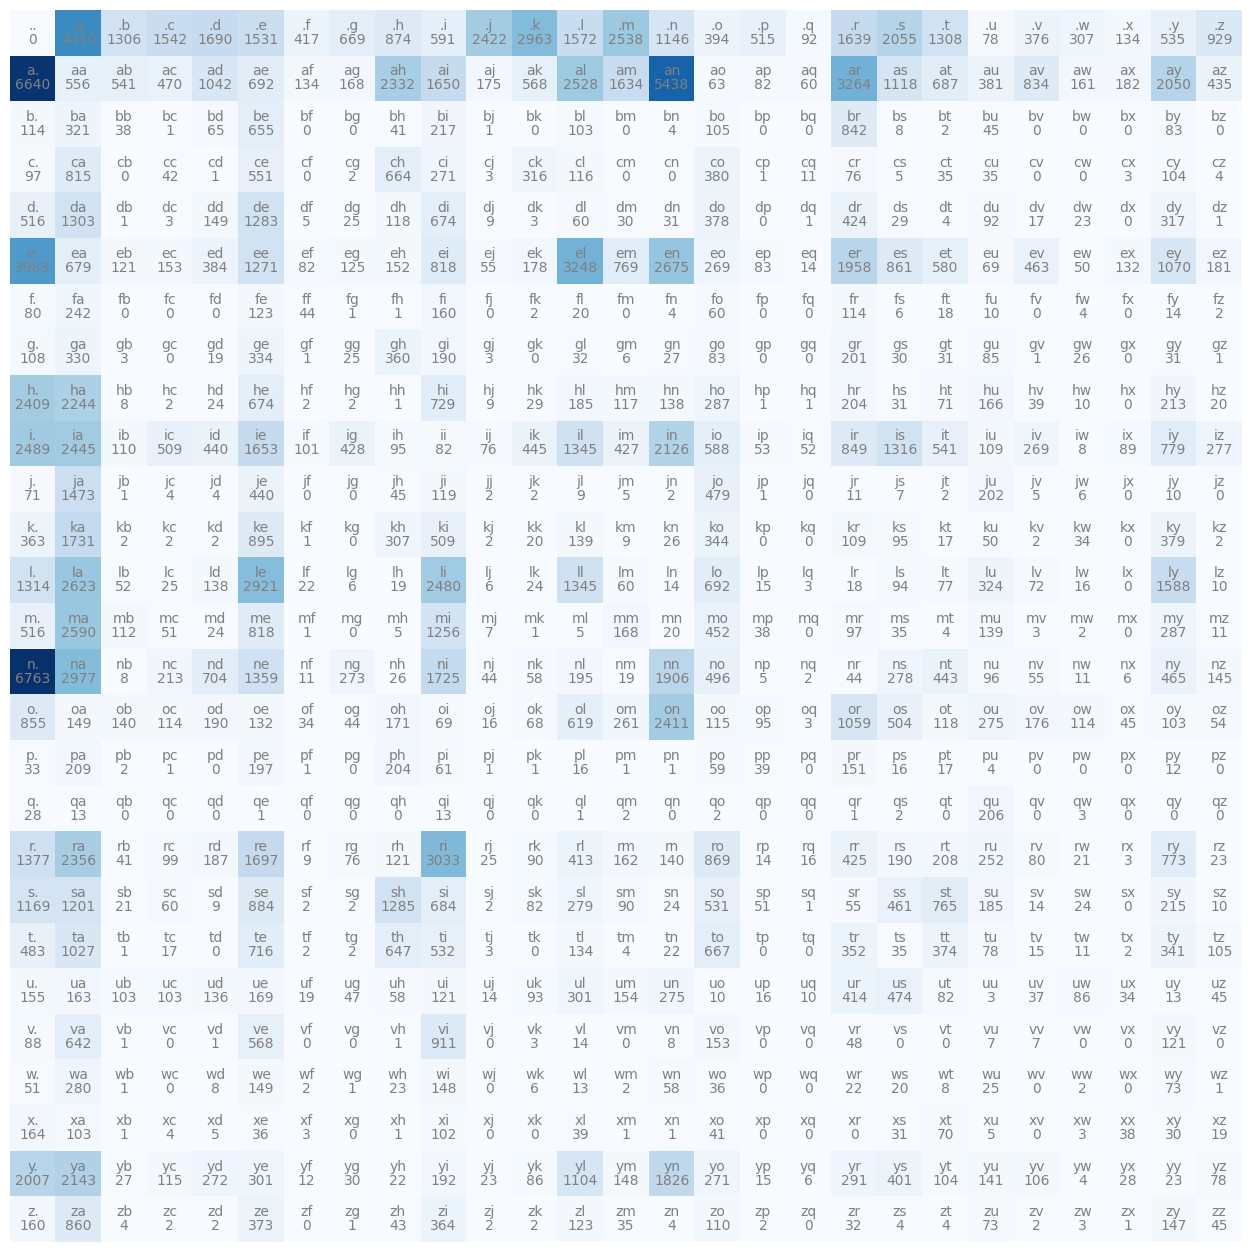

In [4]:
# Matplotlib plots are displayed inline within the notebook itself, instead of opening in a separate window.
%matplotlib inline 

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')     
plt.axis('off')
plt.show()

In the below code we explicitely convert the N[0] to float, but we will get the same result even if we don't convert it since:


When performing division (/) between integer tensors, PyTorch automatically promotes the output type to torch.float32. 
We just did it here for clarity and avoiding unexpected type issues.

In [5]:
# first row, and we want to sample from this
N[0]
p = N[0].float() # convert to float since we want to normalize these counts
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

Why using the Generator? to have a deterministic behavior, get the exact same result whenever we run the code.

What Happens If You Don't Pass the Generator?
If you do not pass a generator (generator=g) to torch.rand(3), PyTorch will use the global random number generator instead of the manually seeded generator g. This means:

- The random numbers generated in torch.rand(3) will be different unless the global random seed was set earlier.

- Every time you run the code, it might produce different values because it will rely on the default global RNG state.

- If you had used the manually seeded generator g, the output would be deterministic (always the same random values for the given seed).


In [6]:
# Evey time I run the below code, I get a different result.
p = torch.rand(3)
p = p / p.sum()
p

tensor([0.0301, 0.3357, 0.6342])

In [7]:
# Every time I run the code, I get the same result.
g = torch.Generator().manual_seed(SEED)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

Here, we expect 60% of the samples to have index 0, and 30% to have index 1, and 10% to have index 2.

In [8]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [9]:
p = N[0].float()
p =  p / p.sum()
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'h'

These samples are terrrible, why?

In [10]:
for i in range(10):
    ix = 0
    out = []
    while True:
        p = N[ix].float()
        p = p /  p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        out.append(sampled_char)
        if ix == 0:
            break

    print(''.join(out))

deen.
pereltwnigua.
sadryrolyiniydavesole.
rish.
be.
ka.
nn.
jo.
s.
t.


In [11]:
# Have a uniform distribution so that each character has the same probability.
for i in range(10):
    ix = 0
    out = []
    while True:
        p = torch.ones(27) / 27.0
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        out.append(sampled_char)
        if ix == 0:
            break

    print(''.join(out))

aozqabzgvonxwfjpndkpedeshpqtrzgawbl.
deybiiictjfsihquqzzd.
egehkewsjsb.
gjolcvltnyqbensbylyzuwpuqwgzmuhe.
ggqqjqup.
duiijepkeqibbzttgbtnkzhq.
vrmyqgbwtyudzfgoodagaigsoszgkidqbcwltuzqqrqypihmhawpryhrfcnivofayn.
xxoejdppejhdckodwvmbtrvjkgalqkdtlmwugcyhdnfkpyvphcfet.
ecfiljouyxhglanwkrol.
mkqoybqi.


Create the P matrix where every single row contains the probabilities. the probability distribution for the next character where we have the current character.

In [12]:
P = N.float()
P.sum() # sum of all the items in the matrix N, but we want to divide all the rows by their respective sums
print(P.sum(dim=0, keepdim=True).shape) # summing across the first dimention
print(P.sum(dim=0, keepdim=False).shape) # setting the keepdim to False squeezes the respected dimention

# We don't want the sum across the rows, we want it across the columns so we must set the dim to 1
print(P.sum(1, keepdim=True))

# Sth interesting is that the sum across the columns and rows are identical
print(P.sum(0, keepdim=True))

torch.Size([1, 27])
torch.Size([27])
tensor([[32033.],
        [33885.],
        [ 2645.],
        [ 3532.],
        [ 5496.],
        [20423.],
        [  905.],
        [ 1927.],
        [ 7616.],
        [17701.],
        [ 2900.],
        [ 5040.],
        [13958.],
        [ 6642.],
        [18327.],
        [ 7934.],
        [ 1026.],
        [  272.],
        [12700.],
        [ 8106.],
        [ 5570.],
        [ 3135.],
        [ 2573.],
        [  929.],
        [  697.],
        [ 9776.],
        [ 2398.]])
tensor([[32033., 33885.,  2645.,  3532.,  5496., 20423.,   905.,  1927.,  7616.,
         17701.,  2900.,  5040., 13958.,  6642., 18327.,  7934.,  1026.,   272.,
         12700.,  8106.,  5570.,  3135.,  2573.,   929.,   697.,  9776.,  2398.]])


Is it possible to take a (27, 27) matrix; P in this case, and divide it by (27, 1) array?


For broadcasting in Pytorch, When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In our case we have the two tensors with the below dimentions:

28, 28

28, 1


If we start from right, 28 is not equal to 1 but one of them is 1(it copies it 28 times and then perform the element wise division), so we can move to the next element which are equal. So, in our case this operation 

```P / P.sum(dim=1, keepdim=True)```

is broadcastable.

In [13]:
P = N.float()
P = P / P.sum(dim=1, keepdim=True)
P[0].sum()  # it must be equal to 1

tensor(1.)

In [14]:
for i in range(10):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        out.append(sampled_char)
        if ix == 0:
            break

    print(''.join(out))

le.
l.
mragi.
celadahereneyuerlizeniquiai.
kowasiarey.
min.
t.
zolabesh.
beriamein.
chs.


What would happen if we set the keepdim to False?

P = N.float()           # shape: (28, 28)

P = P / P.sum(dim=1)    # shape: (28)


These two tensors are broadcastable, and the result shape is (28, 28), but the sum of the items in a row is not equal to 1. This is because we are normalizing columns instead of normalizing the rows.

In [15]:
P = N.float()
P = P / P.sum(dim=1)
print(P[0].sum())
for i in range(10):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        out.append(sampled_char)
        if ix == 0:
            break

    print(''.join(out))

tensor(7.0225)
dexclikewhayjolueech.
biyusojuxorrithrarteprajuquxfffauxxeshouwyngulppexixtygharspfa.
gurl.
molish.
yxxxytthesmazldogeprazpolla.
pppajarwthaviugwfgwhwsqulyowyn.
jexxahzliffa.
shabebddimadhuqubuw.
khastymemyyvvicerbruffffrowiggwydouvaxxthnzzh.
ens.


The difference between ```P /= P.sum(dim=1, keepdim=True)``` and ```P = P / P.sum(dim=1, keepdim=True)``` ?

The second one is the in-place operation which is faster since it doesn't make a copy of the data.

In [16]:
P = N.float()
P /= P.sum(dim=1, keepdim=True)

for i in range(20):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

aeeli.
iye.
l.
anan.
a.
eyn.
jaya.
kied.
jarikly.
ky.
derirk.
amalyn.
de.
ues.
hudatlan.
k.
julstonissurenibeleror.
jahreri.
ke.
di.


Until now, we have trained a bigram language model whose parameters are the items of the tensor P.

Now we need to measure the quality of this model.

In [22]:
log_likelihood = 0.0
n = 0
# for w in words:
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob) # the more negative, the worse 
        log_likelihood += logprob
        n += 1 
        print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

print(log_likelihood) # when all the probabilities are 1, the log of those probs is 0, and the log_liklihood is 0 too which is the ideal, but the more negative it become, it is undesirable!
neg_log_likelihood = -log_likelihood
normalized_nll = neg_log_likelihood / n  # get the average log likelihood, the lower it is, the better
print(neg_log_likelihood)
print(normalized_nll)

.a: 0.1377, -1.9829
an: 0.1605, -1.8296
nd: 0.0384, -3.2594
dr: 0.0771, -2.5620
re: 0.1336, -2.0127
ej: 0.0027, -5.9171
jq: 0.0000, -inf
q.: 0.1029, -2.2736
tensor(-inf)
tensor(inf)
tensor(inf)


To make sure we won't have 0 probabilities in our model distribution, we will add 1 to all of the items of N
The larger the number we add, the more uniform the probability distribution

In [23]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

In [24]:
log_likelihood = 0.0
n = 0
# for w in words:
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob) # the more negative, the worse 
        log_likelihood += logprob
        n += 1 
        print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

print(log_likelihood) # when all the probabilities are 1, the log of those probs is 0, and the log_liklihood is 0 too which is the ideal, but the more negative it become, it is undesirable!
neg_log_likelihood = -log_likelihood
normalized_nll = neg_log_likelihood / n  # get the average log likelihood, the lower it is, the better
print(neg_log_likelihood)
print(normalized_nll)

.a: 0.1376, -1.9835
an: 0.1604, -1.8302
nd: 0.0384, -3.2594
dr: 0.0770, -2.5646
re: 0.1334, -2.0143
ej: 0.0027, -5.9004
jq: 0.0003, -7.9817
q.: 0.0970, -2.3331
tensor(-27.8672)
tensor(27.8672)
tensor(3.4834)


Difference between ```torch.tensor``` and ```torch.Tensor```:

the first one infers the data type automatically while the second one returns a ```torch.floatTensor```
It is advised to use the ````torch.tensor```

In [ ]:
# Create the training set of all the bigrams

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float() # input to the NN: one-hot encoding
yenc = F.one_hot(ys, num_classes=27).float()

torch.float32

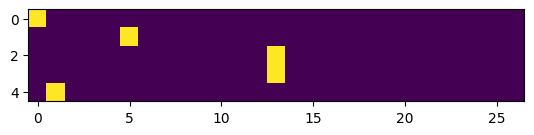

In [36]:
plt.imshow(xenc)
xenc.dtype # when feeding the input data to the NNs, we want the data to be of type float not integers!

Let's just define a sinle neuron for now

In [52]:
W = torch.randn((27, 1), generator=g)
xenc @ W # @ is a matrix multiplication in Pytorch

tensor([[-0.2473],
        [-1.4539],
        [-0.8063],
        [-0.8063],
        [-1.8178]])

In [53]:
W = torch.randn((27, 27))
xenc @ W 

tensor([[ 1.0741,  1.3219, -0.2588,  0.1872,  0.2138,  0.4172, -0.5669, -0.6589,
          0.6121, -0.3712, -1.4580, -0.4602, -0.0705,  0.4683, -0.1937,  1.6448,
         -0.0428, -0.2680, -0.5087,  1.6216,  1.5375,  1.7619, -0.6668, -1.8551,
          0.5900, -0.2727,  0.2898],
        [-0.2433, -1.0478, -0.3085,  0.8141, -0.3664, -1.1179,  1.3433,  1.7498,
         -0.2051, -0.6150, -1.5340,  0.9125, -1.1612, -1.2017, -0.4940, -0.3366,
          0.2286, -0.2937, -0.8877,  1.1369, -0.9216, -0.7424, -0.5624, -0.1566,
         -1.3535,  0.8740,  0.1157],
        [-0.6111, -0.1215,  0.2902,  0.6204, -0.4320, -1.6103,  0.6035,  0.4905,
         -1.7615, -0.8970, -0.7337, -1.9317, -0.4641, -0.9791, -0.7090,  0.6957,
         -0.2377,  0.1752,  1.5053, -0.3055,  1.1968, -0.1115, -0.2303,  0.5316,
         -0.5615, -0.4479,  0.7806],
        [-0.6111, -0.1215,  0.2902,  0.6204, -0.4320, -1.6103,  0.6035,  0.4905,
         -1.7615, -0.8970, -0.7337, -1.9317, -0.4641, -0.9791, -0.7090,  0.6957

In [54]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
W[:, 13]

tensor([ 0.4683,  1.4585, -0.1262, -0.6326, -0.1911, -1.2017,  0.9328, -0.1832,
         0.6498,  0.6653,  1.1064,  0.6649, -1.5079, -0.9791, -1.5327,  0.1614,
         0.3772,  0.4582, -1.2735, -0.2507,  0.8180,  0.1651, -0.9178,  0.7184,
        -0.6483, -2.9812, -1.5149])

In [56]:
(xenc[3] * W[:, 13]).sum()

tensor(-0.9791)

In [57]:
(xenc @ W)[3, 13] # the firing rate of the 13th neuron looking at the 3rd input

tensor(-0.9791)

In [58]:
logits = (xenc @ W) # log-counts
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs

tensor([[0.0625, 0.0800, 0.0165, 0.0257, 0.0264, 0.0324, 0.0121, 0.0110, 0.0394,
         0.0147, 0.0050, 0.0135, 0.0199, 0.0341, 0.0176, 0.1105, 0.0204, 0.0163,
         0.0128, 0.1080, 0.0993, 0.1243, 0.0110, 0.0033, 0.0385, 0.0162, 0.0285],
        [0.0242, 0.0108, 0.0227, 0.0698, 0.0214, 0.0101, 0.1185, 0.1779, 0.0252,
         0.0167, 0.0067, 0.0770, 0.0097, 0.0093, 0.0189, 0.0221, 0.0389, 0.0231,
         0.0127, 0.0964, 0.0123, 0.0147, 0.0176, 0.0264, 0.0080, 0.0741, 0.0347],
        [0.0175, 0.0286, 0.0432, 0.0601, 0.0210, 0.0065, 0.0591, 0.0528, 0.0055,
         0.0132, 0.0155, 0.0047, 0.0203, 0.0121, 0.0159, 0.0648, 0.0255, 0.0385,
         0.1455, 0.0238, 0.1069, 0.0289, 0.0257, 0.0550, 0.0184, 0.0206, 0.0705],
        [0.0175, 0.0286, 0.0432, 0.0601, 0.0210, 0.0065, 0.0591, 0.0528, 0.0055,
         0.0132, 0.0155, 0.0047, 0.0203, 0.0121, 0.0159, 0.0648, 0.0255, 0.0385,
         0.1455, 0.0238, 0.1069, 0.0289, 0.0257, 0.0550, 0.0184, 0.0206, 0.0705],
        [0.1304, 0.0128,

In [59]:
probs[0]

tensor([0.0625, 0.0800, 0.0165, 0.0257, 0.0264, 0.0324, 0.0121, 0.0110, 0.0394,
        0.0147, 0.0050, 0.0135, 0.0199, 0.0341, 0.0176, 0.1105, 0.0204, 0.0163,
        0.0128, 0.1080, 0.0993, 0.1243, 0.0110, 0.0033, 0.0385, 0.0162, 0.0285])

In [61]:
nlls = torch.zeros(5)

for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print('-------')
    print(f'bigram example {i + 1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print(f'Input to the neural net: {x}')
    print(f'Output probabilities from the neural net: {probs[i]}')
    print(f'Label: {y}')
    p = probs[i, y]
    print(f'Probability assigned by the net to the correct character: {p.item()}')
    logp = torch.log(p)
    print('Log Likelihood: ', logp.item())
    nll = - logp
    print(f'Negative Log Likelihhod: {nll.item()}')
    nlls[i] = nll

print('=======')
print(f"Average negative log likelihood, i.e. loss = {nlls.mean().item()}")

-------
bigram example 1: .e (indexes 0, 5)
Input to the neural net: 0
Output probabilities from the neural net: tensor([0.0625, 0.0800, 0.0165, 0.0257, 0.0264, 0.0324, 0.0121, 0.0110, 0.0394,
        0.0147, 0.0050, 0.0135, 0.0199, 0.0341, 0.0176, 0.1105, 0.0204, 0.0163,
        0.0128, 0.1080, 0.0993, 0.1243, 0.0110, 0.0033, 0.0385, 0.0162, 0.0285])
Label: 5
Probability assigned by the net to the correct character: 0.03238692134618759
Log Likelihood:  -3.4300005435943604
Negative Log Likelihhod: 3.4300005435943604
-------
bigram example 2: em (indexes 5, 13)
Input to the neural net: 5
Output probabilities from the neural net: tensor([0.0242, 0.0108, 0.0227, 0.0698, 0.0214, 0.0101, 0.1185, 0.1779, 0.0252,
        0.0167, 0.0067, 0.0770, 0.0097, 0.0093, 0.0189, 0.0221, 0.0389, 0.0231,
        0.0127, 0.0964, 0.0123, 0.0147, 0.0176, 0.0264, 0.0080, 0.0741, 0.0347])
Label: 13
Probability assigned by the net to the correct character: 0.009297664277255535
Log Likelihood:  -4.67799186706543

Optimiztion

In [ ]:
W = torch.randn((27, 27), requires_grad=True, generator=g)

# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()


In [ ]:
# backward pass
W.grad = None # set the gradients to 0
loss.backward()

tensor(3.6222)

In [ ]:
W.data += -0.1 * W.grad